In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# import h10
from tqdm import tqdm
from nicks_plot_utils import *

import boost_histogram as bh
from scipy import stats
from pyarrow import csv


w_bins = np.array([1.1, 1.12, 1.14, 1.16, 1.18, 1.2, 1.22, 1.24, 1.26, 1.28, 1.3,
                       1.32, 1.34, 1.36, 1.38, 1.4, 1.42, 1.44, 1.46, 1.48, 1.5, 1.52,
                       1.54, 1.56, 1.58, 1.6, 1.62, 1.64, 1.66, 1.68, 1.7, 1.72, 1.74, 1.76, 1.78, 1.8, 1.82])

q2_bins = np.array([1.3, 1.56, 1.87, 2.23, 2.66, 3.5])

theta_bins = np.array([-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

In [2]:
# df = pd.read_csv("/Users/tylern/physics_code/build/result.csv", names=['type','w','q2', 'theta', 'phi'])

pyTable = csv.read_csv(
        "/Users/tylern/physics_code/build/result.csv",
        read_options=csv.ReadOptions(
            use_threads=True, column_names=['type','w','q2', 'theta', 'phi']))

df = pyTable.to_pandas(strings_to_categorical=True)

In [3]:
df['w_bin'] = pd.cut(df['w'], bins=w_bins, include_lowest=True)
df['q2_bin'] = pd.cut(df['q2'], bins=q2_bins, include_lowest=True)

df.dropna(inplace=True)

bins_w = np.sort(pd.unique(df['w_bin']))
bins_q2 = np.sort(pd.unique(df['q2_bin']))


num = min(np.sum(df.type == "norad"),np.sum(df.type == "rad"))
df = pd.concat([df[df.type == "norad"].head(num), df[df.type == "rad"].head(num)])

In [4]:
print(np.sum(df.type == "norad"))

20321795


In [5]:
print(np.sum(df.type == "rad"))

20321795


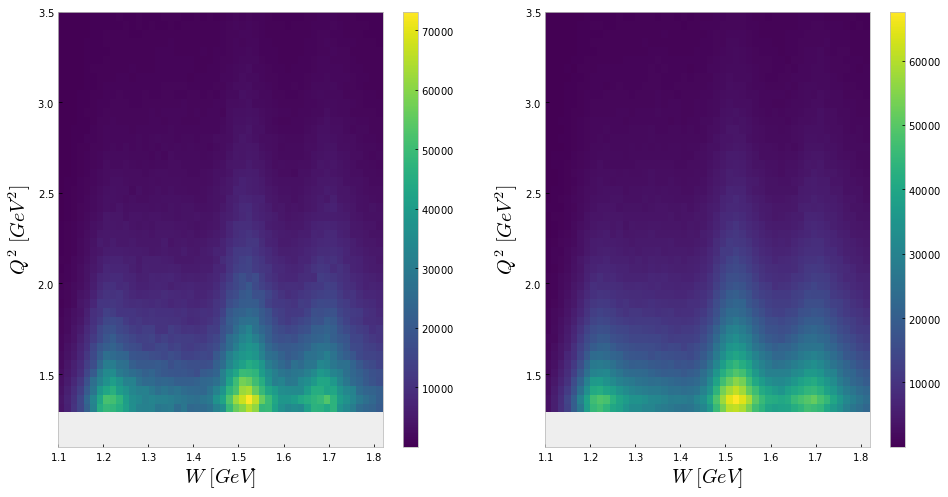

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[16,8])

hist = Hist2D(df[df.type == "norad"].w, df[df.type == "norad"].q2, 
              xname="$W~[GeV]$", yname="$Q^2~[GeV^2]$", 
              xrange=[1.1, 1.82], xbins=50, yrange=[1.1, 3.5], ybins=50)

hist.plot(ax=ax[0], colorbar=True, density=False, zeros=False)

hist2 = Hist2D(df[df.type == "rad"].w, df[df.type == "rad"].q2, 
               xname="$W~[GeV]$", yname="$Q^2~[GeV^2]$", 
               xrange=[1.1, 1.82], xbins=50, yrange=[1.1, 3.5], ybins=50)

hist2.plot(ax=ax[1], colorbar=True, density=False, zeros=False)

plt.show()

In [ ]:
corr = []
for q2 in bins_q2:
    for w in bins_w:
        data = df[(df.w_bin == w) & (df.q2_bin == q2)]
        corr.append([str(np.round(w.left,3)), str(np.round(q2.left,3)), len(data[data.type == "rad"]), len(data[data.type == "norad"])])


In [ ]:
ratio = pd.DataFrame(corr, columns=['w_left', 'q2_left', 'rad', 'norad'])

ratio['one_over_R'] = ratio.norad/ratio.rad
ratio['R'] = ratio.rad/ratio.norad

#print(ratio.q2_left.unique())
x = print(ratio.q2_left.unique())


w_map = {
'1.099' : '1.1', 
'1.12' : '1.12' , 
'1.14' : '1.14' , 
'1.16' : '1.16' , 
'1.18' : '1.18' , 
'1.2' : '1.2' , 
'1.22' : '1.22' , 
'1.24' :'1.24'  ,
'1.26' : '1.26' , 
'1.28' : '1.28' , 
'1.3' : '1.3' , 
'1.32' : '1.32' , 
'1.34' : '1.34' , 
'1.36' : '1.36' , 
'1.38' : '1.38' , 
'1.4' :'1.4' ,
'1.42' :'1.42'  ,
'1.44' :'1.44'  ,
'1.46' :'1.46'  ,
'1.48' :'1.48'  ,
'1.5' :'1.5'  ,
'1.52' :'1.52'  ,
'1.54' :'1.54'  ,
'1.56' :'1.56'  ,
'1.58' :'1.58'  ,
'1.6' : '1.6',
'1.62' : '1.62',
'1.64' : '1.64',
'1.66' : '1.66',
'1.68': '1.68',
'1.7': '1.7',
'1.72': '1.72',
'1.74': '1.74',
'1.76' : '1.76',
'1.78' : '1.78',    
'1.8' : '1.8', }

ratio.w_left = ratio.w_left.map(w_map)


q2_map = {'1.099' : '1.1',
          '1.299' : '1.1',
           '1.3': '1.3', 
        '1.56': '1.56', 
        '1.87': '1.87', 
        '2.23': '2.23', 
        '2.66': '2.66', 
        '3.5': '3.5'}



ratio.dropna(inplace=True)

ratio.q2_left = ratio.q2_left.map(q2_map)
#print(ratio.q2_left.unique())
y = print(ratio.q2_left.unique())

print(x == y)
ratio.head()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,8])
for _q2_ in pd.unique(ratio.q2_left):
    cut = (ratio.q2_left == _q2_)
    yerr = 1/np.sqrt(ratio[cut].norad)
    scat = ax.errorbar(np.float32(ratio[cut].w_left), ratio[cut].one_over_R, fmt='.', label=f'{_q2_} GeV$^2$', yerr=yerr)
# ax.set_ylim(0.95, 1.25)
plt.title("Radiative Corrections")
plt.legend(title="$Q^2$ Bin")
plt.ylabel("1/R")
plt.xlabel("$W (GeV)$")
plt.axhline(1.0, zorder=0, alpha=0.2, c='k')
plt.show()

In [ ]:
# ratio.to_csv("/Users/tylern/Data/e1d/radcorr/radcorr_e99.csv", index=False, header=True)